# Project 03: Fake News Detector

## Danh sách thành viên và phân công công việc

## Các thư viện sử dụng

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from vncorenlp import VnCoreNLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
import pickle

## Đọc dữ liệu

Dữ liệu và thư viện được sử dụng:
- Bộ dữ liệu vn_news_223_tdlfr: Dữ liệu 223 record bản tin tiếng Việt.
- Stop word và xử lý Tokenizer sử dụng dữ liệu và tool như gợi ý.

### Bộ dữ liệu VNFD

In [2]:
#pd.set_option('display.max_colwidth', None)
vnfd_df = pd.read_csv('vn_news_223_tdlfr.csv')
vnfd_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Dữ liệu về Stop word

In [3]:
def read_stopword_file(path):
    stopword_file = open(path, "r", encoding = 'utf-8')
    sw = stopword_file.readlines()
    stopword_file.close()
    sw = [x.replace('\n', '') for x in sw]
    return sw

In [4]:
sw = read_stopword_file("vietnamese-stopwords.txt")

## Tiền xử lý

Trước khi xác định các bước tiền xử lý, nhóm đã quan sát trên bộ dữ liệu và có những đánh giá sau:
- Theo như quan sát trên dữ liệu, những đường link thường sẽ dài hơn 1 chữ đơn tiếng Việt thông thường, tuy nhiên một số nơi có chữ bị gộp lại, chẳng hạn bởi '\n' hay dùng tiếng nước ngoài như 'Photoshop'. Như vậy, loại bỏ link và kí tự đặc biệt sẽ được xử lý đồng thời theo thứ tự sau:
    - Loại bỏ '\n', '\t'.
    - Tìm link trong chuỗi (phân tách chuỗi bằng kí tự ' ', sau đó lấy ra phần tử có độ dài > 15 (15 không phải con số thực sự chính xác nhưng hầu hết những từ có nghĩa, kể cả từ tiếng nước ngoài thông dụng ít khi có độ dài ở mức này. Những trường hợp còn sót lại thì xem như một từ có nghĩa hoặc tên riêng --!).
    - Loại bỏ các kí tự đặc biệt khác trừ ' '.
    - Xóa bỏ các khoảng trắng bị lặp.
- Bước Lemmatize có lẽ không cần thực hiện vì tiếng Việt không có những chữ cái như vậy, hoặc nếu có xuất hiện trong văn bản, đó có thể là do viết lỗi, teencode hoặc có nghĩa trong văn cảnh đó.

Các bước tiền xử lý:
- Loại bỏ các kí tự đặc biệt và đường link.
- Chuyển chữ hoa về chữ thường (ta tiến hành bước này trước vì dữ liệu về stop word đều được viết thường).
- Loại bỏ stop word.
- Tokenizer.

#### Loại bỏ kí tự đặc biệt và đường link

In [5]:
def remove_single_spec_char(char):
    if char != ' ':
        if char.isalnum() == False:
            char = ' '
    return char

In [6]:
#Do hàm trên không tìm được những kí tự như \n hay \t nên ta sẽ xử lý riêng.
def remove_specChar_link(string):
    result = ''
    string = string.replace('\n', ' ').replace('\t', ' ')
    sub_text = string.split(' ')
    links = [link for link in sub_text if len(link) > 15]
    for link in links:
        string = string.replace(link, ' ')
    for char in string:
        result = result + remove_single_spec_char(char)
    result = ' '.join(result.split())    
    return result

In [7]:
#TEST
test_string = remove_specChar_link(vnfd_df.text[1])
test_string

'Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần phi thể thao của đội bóng Sáng 19 6 Thủ tướng Nhật Bản Shinzo Abe công khai gửi lời xin lỗi tới Nhật hoàng và toàn bộ người dân vì tinh thần thi đấu phi thể thao của đội tuyển Nhật tại World Cup 2018 Với tinh thần của những võ sĩ đạo Samurai nhưng đội tuyển Nhật Bản đã có những hành động thiếu tinh thần thượng võ trong thi đấu tại World Cup để lại nhiều chỉ trích và bất bình cho toàn dân làm mất hình ảnh kiên cường của người dân Nhật Bản trên đấu trường quốc tế Là người đứng đầu tôi xin thành thật nhận trách nhiệm và gửi lời xin lỗi sâu sắc tới nhân dân ông Abe cúi đầu nhận trách nhiệm về mình Tôi cảm phục hành động này của Thủ tướng Nhật Ông ấy ý thức rất cao về hình ảnh danh dự quốc gia Nước Nhật được thế giới tôn trọng kính nể không phải vì nước này là cường quốc kinh tế mà chính là cường quốc về lòng tự trọng'

#### Chuyển chữ hoa về chữ thường

In [8]:
#TEST
test_string = test_string.lower()
test_string

'thủ tướng nhật cúi đầu xin lỗi vì tinh thần phi thể thao của đội bóng sáng 19 6 thủ tướng nhật bản shinzo abe công khai gửi lời xin lỗi tới nhật hoàng và toàn bộ người dân vì tinh thần thi đấu phi thể thao của đội tuyển nhật tại world cup 2018 với tinh thần của những võ sĩ đạo samurai nhưng đội tuyển nhật bản đã có những hành động thiếu tinh thần thượng võ trong thi đấu tại world cup để lại nhiều chỉ trích và bất bình cho toàn dân làm mất hình ảnh kiên cường của người dân nhật bản trên đấu trường quốc tế là người đứng đầu tôi xin thành thật nhận trách nhiệm và gửi lời xin lỗi sâu sắc tới nhân dân ông abe cúi đầu nhận trách nhiệm về mình tôi cảm phục hành động này của thủ tướng nhật ông ấy ý thức rất cao về hình ảnh danh dự quốc gia nước nhật được thế giới tôn trọng kính nể không phải vì nước này là cường quốc kinh tế mà chính là cường quốc về lòng tự trọng'

#### Loại bỏ stop word

In [9]:
def remove_stopword(string, stop_word):
    for stop_word in stop_word:
        string = string.replace(' ' + stop_word + ' ', ' ')
    return string

In [10]:
#TEST
test_string = remove_stopword(test_string, sw)
test_string

'thủ tướng nhật cúi đầu lỗi tinh thần phi thể thao đội bóng 19 6 thủ tướng nhật shinzo abe công khai gửi lỗi nhật hoàng toàn dân tinh thần thi đấu phi thể thao đội tuyển nhật world cup 2018 tinh thần võ sĩ đạo samurai đội tuyển nhật hành động tinh thần thượng võ thi đấu world cup trích bất bình toàn dân hình ảnh kiên cường dân nhật đấu trường quốc tế đứng đầu thành trách nhiệm gửi lỗi sâu sắc nhân dân abe cúi đầu trách nhiệm cảm phục hành động thủ tướng nhật thức hình ảnh danh dự quốc gia nhật giới tôn trọng kính nể cường quốc kinh tế cường quốc trọng'

#### Tokenizer

In [11]:
annotator = VnCoreNLP('VnCoreNLP-1.1.1.jar', annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')
def tokenizer(string):
    word_segmented_text = annotator.tokenize(string)[0]
    return word_segmented_text

In [12]:
#TEST
test_string = tokenizer(test_string)
test_string[0][:10]

'thủ_tướng'

#### Tổng hợp tiền xử lý

In [13]:
def text_preprocessing(text, stop_word):
    new_text = remove_specChar_link(text)
    new_text = new_text.lower()
    new_text = remove_stopword(new_text, stop_word)
    return new_text

def preprocessing(data):
    sub_data = data.copy()
    stop_word = read_stopword_file("vietnamese-stopwords.txt")
    sub_data.text = sub_data['text'].apply(lambda x: text_preprocessing(x, stop_word))
    return sub_data

In [14]:
sub_data = preprocessing(vnfd_df)
sub_data

,text,domain,label
0,thủ tướng abe cúi đầu lỗi hành động phi thể th...,binhluan.biz,1
1,thủ tướng nhật cúi đầu lỗi tinh thần phi thể t...,www.ipick.vn,1
2,choáng trưởng đeo khăn quàng quẩy banh sân khấ...,tintucqpvn.net,1
3,chưa nhạc kpop hát giáo sư nguyễn lân dũng thà...,tintucqpvn.net,1
4,đại học hutech áp dụng cải tiếq việt học 2018 ...,www.gioitreviet.net,1
...,...,...,...
218,siêu máy bay a350 chở cđv việt nam đi malaysia...,dantri.com.vn,0
219,thưởng 20 000 usd đội tuyển cờ vua việt nam ol...,dantri.com.vn,0
220,trường sơn giành hcv giải cờ vua đồng đội giới...,dantri.com.vn,0
221,chuyện chàng sinh viên luật kiện tướng lê tuấn...,dantri.com.vn,0


## Khám phá dữ liệu

#### Kiểm tra loại dữ liệu và dữ liệu thiếu

In [15]:
sub_data.shape

(223, 3)

In [16]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


Nhận xét:
- Domain thể hiện tên miền của bài báo, ta có thể chuyển về dạng string.
- Text và Label xem chừng đã có kiểu dữ liệu phù hợp.
- Dữ liệu không có cột nào bị thiếu.

#### Phân bố của class

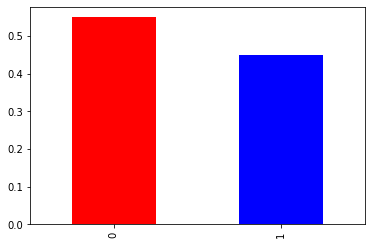

In [17]:
class_per = round(sub_data.label.value_counts()/len(sub_data), 2)
class_per.plot(kind = 'bar', color = ['r', 'b']);

Nhận xét: Tỉ lệ giữa 2 class trong bộ dữ liệu không có sự chênh lệch quá lớn.

## Mô hình hóa

### Split train - test set

In [18]:
x_train,x_test,y_train,y_test=train_test_split(sub_data.text, sub_data.label, test_size=0.2, random_state=42)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(sub_data.text, sub_data.label, test_size=0.2, random_state=7)

In [20]:
tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8', stop_words=sw, tokenizer = tokenizer)

In [21]:
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

### Mô hình 1: Sử dụng Passive Aggressive Classifier

In [22]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
pac_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,pac_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 88.89%


In [23]:
# Save Model
with open('PAC_pkl', 'wb') as files:
    pickle.dump(pac, files)

### Mô hình 2: Sử dụng Logistic Regression

In [24]:
LRC = LogisticRegression()
LRC.fit(tfidf_train, y_train)
lrc_pred = LRC.predict(tfidf_test)
score = accuracy_score(y_test, lrc_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 91.11%


In [25]:
# Save Model
with open('LRC_pkl', 'wb') as files:
    pickle.dump(LRC, files)